In [9]:
import os
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import cartopy.util as cutil
import cmocean
import matplotlib
import matplotlib.animation as animation
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [14]:
def spatial_obs_plot(dfs, cmap_info, save_info):
    fig, axes = plot_stationary_sp(nplots=len(dfs.keys()))

    for i, ((key, ds), ax) in enumerate(zip(dfs.items(), axes)):

        if not cmap_info["shared"]:
            levels = cmap_info["levels"][i]
            units = cmap_info["units"][i]
            cmap = cmap_info["cmap"][i]
        else: 
            levels = cmap_info["levels"]
            units = cmap_info["units"]
            cmap = cmap_info["cmap"]

        # Create contour plot
        # dsi = interpolate_seaice_gap(ds["ds"].values)
        img = ax.contourf(
            ds["ds"].lon.values,
            ds["ds"].lat.values,
            ds["ds"].values,
            transform=ccrs.PlateCarree(), 
            levels=levels,
            extend="both",
            cmap=cmap,
        )

        # Set Tick Labels
        gl = ax.gridlines(draw_labels=True)
        print(gl)
        for ea in gl.label_artists:
            print(ea)
            print(ea[0])
            print(ea[1])
            print(ea[2])
            if ea[1]==False:
                tx = ea[2]
                xy = tx.get_position()
                print(xy)
                # if xy[0]==138:
                #     tx.set_position([126, xy[1]])

        
        # Add ice edge
        if key.split("_")[-1] == "siconc":
            if "edge" in ds.keys():
                dsi = interpolate_seaice_gap(ds["edge"].values)
                ax.contour(
                    ds["edge"].lon.values,
                    ds["edge"].lat.values,
                    dsi,
                    transform=ccrs.PlateCarree(), 
                    levels=[.15],
                    colors="navy"
                )
            if "edge_clim" in ds.keys():
                dsi = interpolate_seaice_gap(ds["edge_clim"].values)
                ax.contour(
                    ds["edge_clim"].lon.values,
                    ds["edge_clim"].lat.values,
                    ds["edge_clim"].values,
                    transform=ccrs.PlateCarree(), 
                    levels=[.15],
                    colors="magenta",
                )
            if "edge_ens" in ds.keys():
                ax.contour(
                    ds["edge_ens"].lon.values,
                    ds["edge_ens"].lat.values,
                    ds["edge_ens"].values,
                    transform=ccrs.PlateCarree(), 
                    levels=[.15],
                    colors="blue",
                )

        # Plot Winds if given
        if "wind" in ds.keys():
            lat_step, lon_step = 5, 5 
            ax.quiver(
                x=ds["wind"][0].lon[::lon_step],
                y=ds["wind"][0].lat[::lat_step],
                u=ds["wind"][0].values[::lat_step, ::lon_step], 
                v=ds["wind"][1].values[::lat_step, ::lon_step], 
                color="black", 
                scale=ds["wind"][2],
                transform=ccrs.PlateCarree(),
            )
        if "include_regions" in ds.keys():
            regional_bounds = {
                "ross": (155, 215, "ROSS"),
                "amundsen": (215, 255, "AM"),
                "bellingshausen": (255, 295, "BS"),
                "weddell": (295, 360, "WE"),
                "south_indian": (0, 75, "SI"),
                "south_west_pacific": (75, 155, "SWP"),
            }

            lat_min, lat_max = -90, -40
            for region, bounds in regional_bounds.items():
                ax.plot(
                    [bounds[0], bounds[0]], 
                    [lat_max, lat_min], 
                    color="black", linewidth=2, linestyle="solid", transform=ccrs.PlateCarree(), zorder=10
                )
                ax.text(
                    (bounds[0]+ bounds[1])/2,
                    -57,
                    bounds[-1],
                    fontsize=12,
                    color="black",
                    fontweight="bold",
                    transform=ccrs.PlateCarree()
                )

        if not cmap_info["shared"]:
            cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.046, pad=0.04)
            cbar.ax.set_title(units)
            if "ticks" in cmap_info.keys():
                cbar.set_ticks(cmap_info["ticks"])
                cbar.set_ticklabels(cmap_info["ticks"])

        # Set properties
        if "title" in ds.keys():
            ax.set_title(ds["title"], loc="right", fontweight="bold", fontsize=12)

        if "left_title" in ds.keys():
            ax.set_title(ds["left_title"], loc="left", fontweight="bold", fontsize=16)

    if len(dfs) == 3: 
        fraction = .016
    elif len(dfs) == 2: 
        fraction = .026

    if cmap_info["shared"]:
        cbar = fig.colorbar(img, ax=axes.ravel().tolist(), orientation="vertical", fraction=fraction, pad=0.04)
        cbar.ax.set_title(cmap_info["units"])
        if "ticks" in cmap_info.keys():
            cbar.set_ticks(cmap_info["ticks"])
            cbar.set_ticklabels(cmap_info["ticks"])

    if save_info["save"]:
        plt.savefig(save_info["path"], dpi=save_info["dpi"], bbox_inches="tight")

def plot_stationary_sp(nplots: int = 3, minLon: int = -180, maxLon: int = 180):
    """
    TODO: Add Doc String
    Create a stationary centered on south pole (Longitude: [minLon,maxLon]; Latitude: [-90,-60]
    Returns:
        ax, fig
    """
    # Create subplots
    if nplots == 3:
        figsize = [20, 20]
    if nplots == 2:
        figsize = [10, 10]
    if nplots == 1:
        figsize = [5, 5]

    fig, axs = plt.subplots(nrows=1, ncols=nplots, figsize=figsize, subplot_kw=dict(projection=ccrs.SouthPolarStereo()))
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.15)

    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    if nplots == 1:
        axs =  [axs]

    # Add properties to axes
    for ax in axs:
        # Limit the map to -60 degrees latitude and below.
        ax.set_extent([minLon, maxLon, -90, -50], ccrs.PlateCarree())

        ax.gridlines(draw_labels=True, color="black", linestyle="dashed", zorder=101)
        ax.tick_params(which="both", zorder=103)

        ax.add_feature(cartopy.feature.LAND, facecolor="grey", edgecolor="black", zorder=3)
        ax.add_feature(cartopy.feature.OCEAN, facecolor="white")


        ax.set_boundary(circle, transform=ax.transAxes)

    return fig, axs


In [24]:
cesm2_sst_trends = xr.open_dataset('../data/cesm2_ocn-sst_monthly_1950-01_2023-12-trends.nc')
cesm2_atm_trends = xr.open_dataset('../data/cesm2_atm_monthly_1950-01_2023-12-trends.nc')

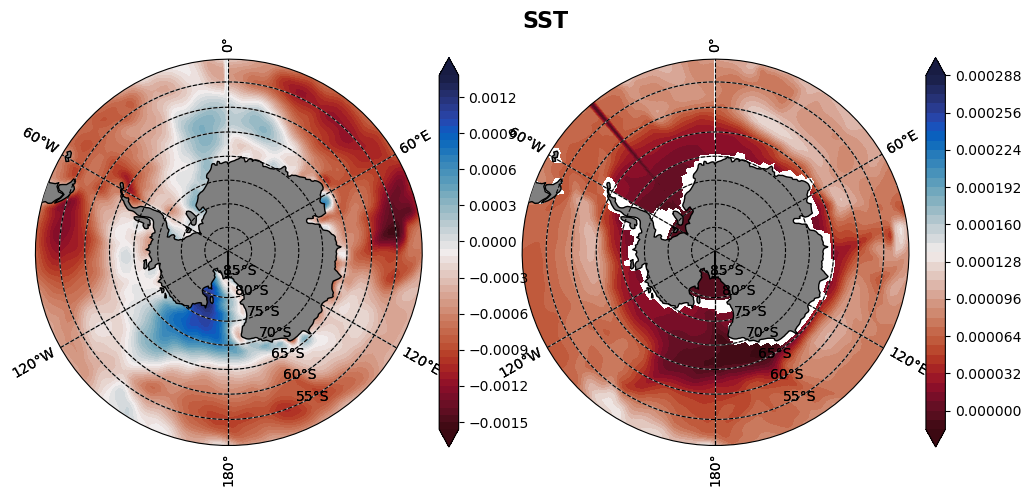

In [25]:
save_info = {
    "save": False,
    "path": "figures/Figure_1a.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": [cmocean.cm.balance_r, cmocean.cm.balance_r],
    "units": ["", ""],
    "shared": False,
    "levels": [50, 50],
}

winds = {
    "right_title": "V10",
    "ds": cesm2_atm_trends["V"].isel(lev=0),

}
sst = {
    "left_title": "SST",
    "ds": cesm2_sst_trends["SST"],

}

spatial_obs_plot(
    dfs={
        "cesm2_winds": winds,
        "cesm2_SST": sst,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)